In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

## Additional training functions

train提供了许多扩展方法，这些方法被添加到Learner（参见下面的列表和详细信息），以及三个简单的回调：

* ShowGraph
* GradientClipping
* BnFreeze
* AccumulateScheduler

## Learner扩展方法
这些方法会自动添加到导入此模块后创建的所有Learner对象中。 它们提供了对许多回调的方便访问，而无需手动创建它们。

<b>fit_one_cycle</b>

`fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Point=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Optional[Collection[Callback]]=None, tot_epochs:int=None, start_epoch:int=None)`

按照1 cycle policy拟合模型。

<b>one_cycle_scheduler</b>

`one_cycle_scheduler(lr_max:float, **kwargs:Any) → OneCycleScheduler`

使用lr_max实例化OneCycleScheduler。

有关详细信息，请参阅OneCycleScheduler。

<b>lr_find</b>

`lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)`

在学习中通过num_it迭代从start_lr到end_lr探索lr。 如果stop_div，当损失发散时停止。

<b>to_fp16</b>

`to_fp16(learn:Learner, loss_scale:float=None, max_noskip:int=1000, dynamic:bool=True, clip:float=None, flat_master:bool=False, max_scale:float=16777216) → Learner`

学习FP16精度模式。

<b>to_fp32</b>

`to_fp32(learn:Learner)`

将学习回到FP32精度模式。

<b>mixup</b>

`mixup(learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True) → Learner`

添加mixup https://arxiv.org/abs/1710.09412

有关详细信息，请参阅MixUpCallback。

## class Interpretation
`Interpretation(learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=<DatasetType.Valid: 2>)`

解释基类，可以继承任务特定的解释类

<b>from_learner</b>

`from_learner(learn:Learner, ds_type:DatasetType=<DatasetType.Valid: 2>)`

获取preds，y_true，loss以从`Learner`构造基类

<b>top_losses</b>

`top_losses(k:int=None, largest=True)`

k最大（/最小）损失和指数，默认为所有损失（按最大值排序）。

例如，在ClassificationInterpretation中使用argmax on preds来设置self.pred_class，而可选的sigmoid用于MultilabelClassificationInterpretation

## class ClassificationInterpretation

`ClassificationInterpretation(learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=<DatasetType.Valid: 2>) :: Interpretation`

分类模型的解释方法。

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = cnn_learner(data, models.resnet18)
learn.fit(1)
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

<b>top_losses</b>

`top_losses(k:int=None, largest=True)`

k最大（/最小）损失和指数，默认为所有损失（按最大值排序）。

In [4]:
interp.top_losses(5)

torch.return_types.topk(
values=tensor([8.2370, 6.6720, 5.6991, 4.8800, 4.1414]),
indices=tensor([1282,  100,   69, 1999,  513]))

<b>plot_confusion_matrix</b>

`plot_confusion_matrix(normalize:bool=False, title:str='Confusion matrix', cmap:Any='Blues', slice_size:int=1, norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs) → Optional[Figure]`

用标题和使用cmap绘制混淆矩阵。

如果标准化，则使用norm_dec数字绘制百分比。 如果您的集合太大，slice_size可用于避免内存不足错误。 kwargs传递给plt.figure。

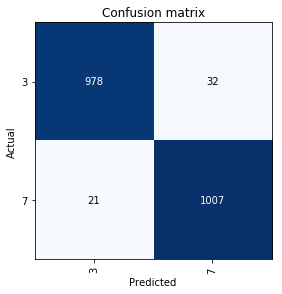

In [5]:
interp.plot_confusion_matrix()

<b>confusion_matrix</b>

`confusion_matrix(slice_size:int=1)`

混淆矩阵作为np.ndarray。

In [7]:
interp.confusion_matrix()

array([[ 978,   32],
       [  21, 1007]], dtype=int64)

<b>most_confused</b>

`most_confused(min_val:int=1, slice_size:int=1) → Collection[Tuple[str, str, int]]`

排序混淆矩阵的最大非对角条目的下降列表，表示为实际，预测，出现次数。

In [9]:
interp.most_confused()

[('3', '7', 32), ('7', '3', 21)]

## Additional callbacks
我们将使用我们的MNIST样本显示以下示例。 像往常一样，on_something方法由fastai库直接调用，无需自己调用它们。

In [10]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

<b>class ShowGraph</b>

`ShowGraph(learn) :: LearnerCallback`

在每个epoch后更新学习者统计数据和指标的图表。

epoch,train_loss,valid_loss,accuracy,time
0,0.144328,0.083137,0.971541,01:09
1,0.082446,0.057601,0.981845,01:09
2,0.054432,0.039774,0.986261,01:08


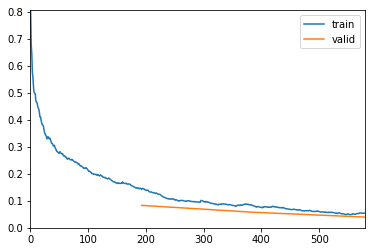

In [11]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, callback_fns=ShowGraph)
learn.fit(3)

<b>on_epoch_end</b>

`on_epoch_end(n_epochs:int, last_metrics:MetricsList, **kwargs) → bool`

如果我们有last_metrics在我们的pbar图中绘制它们

## class GradientClipping

`GradientClipping(learn:Learner, clip:float=0.0) :: LearnerCallback`

在训练期间的梯度剪报。

In [12]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy,
    callback_fns=partial(GradientClipping, clip=0.1))
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.134692,0.087045,0.972522,01:10


<b>on_backward_end</b>

`on_backward_end(**kwargs)`

在优化程序步骤之前剪切渐变。

## class BnFreeze
`BnFreeze(learn) :: LearnerCallback`

冻结所有不可训练的batchnorm层中的移动平均统计数据。

对于requires_grad == False的batchnorm图层，您通常不希望更新其移动平均值统计信息，以避免模型的统计信息与其预先训练的权重不同步。 您可以添加此回调以自动冻结统计信息（在内部，它会在这些图层上调用eval）。

In [13]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, callback_fns=BnFreeze)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.139395,0.082107,0.969087,01:08


<b>on_epoch_begin</b>

`on_epoch_begin(**kwargs:Any)`

在model.train（）之后将bn图层放入eval模式。

## class AccumulateScheduler
`AccumulateScheduler(learn:Learner, n_step:int=1, drop_last:bool=False) :: LearnerCallback`

通过累积渐变，每隔n步累积一步

让我们强制batch_size = 2模仿我们无法将足够的批量样本放入内存的场景。 然后我们可以根据需要设置n_step，以获得有效的batch_size为effective_batch_size = batch_size * n_step。

使用reduce func with reduce ='sum'以计算精确的平均累积梯度也很重要。

用户的另一个重要注意事项是，batchnorm尚未适应累积的渐变。 所以你应该使用这个回调你自己承担风险，直到英雄修复它:)

在这里，我们使用没有batchnorm图层的模型演示此回调，或者您可以使用nn.InstanceNorm或nn.GroupNorm。

In [ ]:
from torchvision.models import vgg11

data = ImageDataBunch.from_folder(path, bs=2)

learn = cnn_learner(data, resnet18, metrics=accuracy, loss_func=CrossEntropyFlat(reduction='sum'),
                    callback_fns=partial(AccumulateScheduler, n_step=16))
learn.fit(1)